In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

In [95]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [96]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all_3_6=data_all[data_all['COT']<3.6]
data_all_10=data_all[data_all['COT']<10]
data_all_25=data_all[data_all['COT']<25]

#data_all=hf.add_MSI_noise(data_all,channel_labels)

(array([ 1004.,   397.,   785.,   645.,   891.,  1942.,  2682.,  3837.,
         8766., 29051.]),
 array([0.04146 , 0.135098, 0.228736, 0.322374, 0.416012, 0.50965 ,
        0.603288, 0.696926, 0.790564, 0.884202, 0.97784 ]),
 <BarContainer object of 10 artists>)

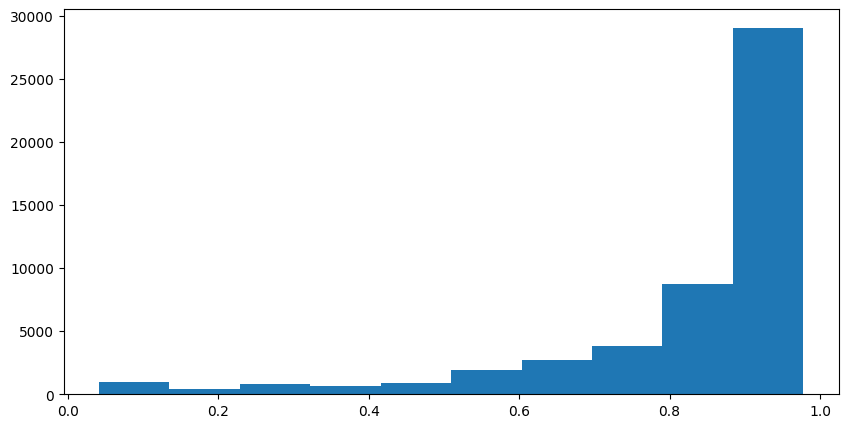

In [136]:
plt.hist(data_mixed['Clear_B12'])

In [97]:
print("Number of data points for 3.6 limit: "+str(len(data_all_3_6)))
print("Number of data points for 10 limit: "+str(len(data_all_10)))
print("Number of data points for 25 limit: "+str(len(data_all_25)))
print("Number of data points for no limit: "+str(len(data_all)))

Number of data points for 3.6 limit: 21786
Number of data points for 10 limit: 53156
Number of data points for 25 limit: 102006
Number of data points for no limit: 150000


In [98]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B12']

X_truth=df_truth[X_labels]

df=data_all.copy()
#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X_3_6=data_all_3_6[X_labels]
y_3_6=data_all_3_6[y_labels]

X_10=data_all_10[X_labels]
y_10=data_all_10[y_labels]

X_25=data_all_25[X_labels]
y_25=data_all_25[y_labels]

X=df[X_labels]
y=df[y_labels]

X_train_3_6, X_test_3_6, y_train_3_6, y_test_3_6=train_test_split(X_3_6,y_3_6,test_size=0.05)
X_train_10, X_test_10, y_train_10, y_test_10=train_test_split(X_10,y_10,test_size=0.05)
X_train_25, X_test_25, y_train_25, y_test_25=train_test_split(X_25,y_25,test_size=0.05)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [99]:
import random

val_size=0.05
validation_indices_3_6=np.array(random.sample(range(len(X_train_3_6['Cloud_B02'])), int(len(X_train_3_6['Cloud_B02'])*val_size)))
train_indices_3_6=[i for i in range(len(X_train_3_6['Cloud_B02'])) if np.any(validation_indices_3_6==i)==False]

validation_indices_10=np.array(random.sample(range(len(X_train_10['Cloud_B02'])), int(len(X_train_10['Cloud_B02'])*val_size)))
train_indices_10=[i for i in range(len(X_train_10['Cloud_B02'])) if np.any(validation_indices_10==i)==False]

validation_indices_25=np.array(random.sample(range(len(X_train_25['Cloud_B02'])), int(len(X_train_25['Cloud_B02'])*val_size)))
train_indices_25=[i for i in range(len(X_train_25['Cloud_B02'])) if np.any(validation_indices_25==i)==False]

validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]



Best model out of total max epochs found at epoch 238
Model all saved...


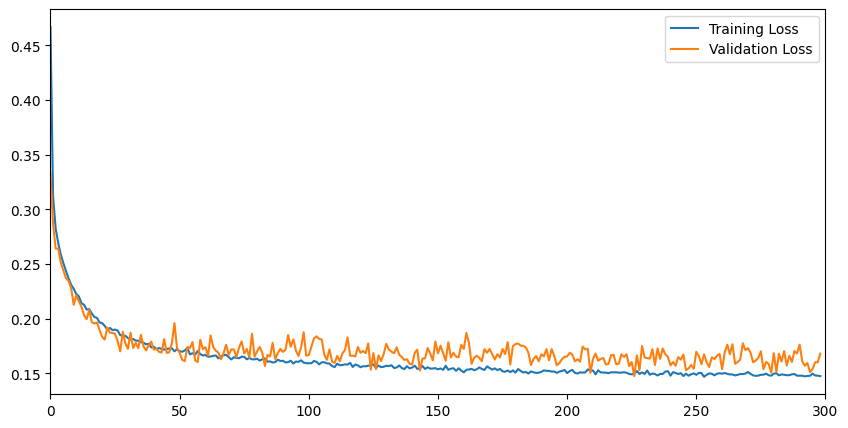

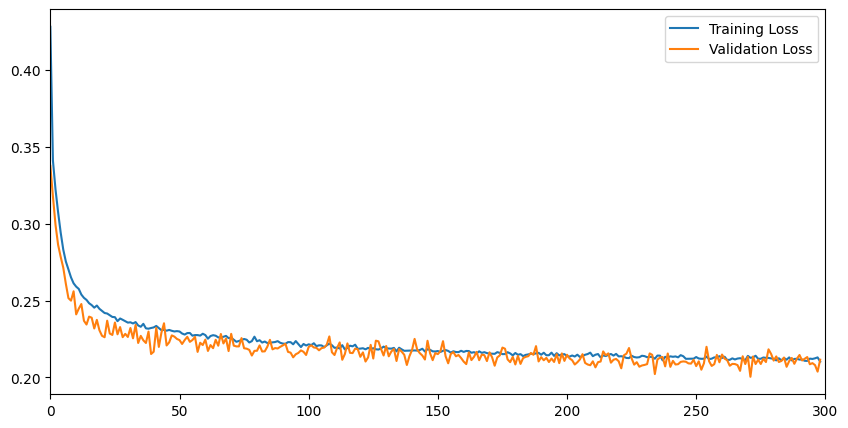

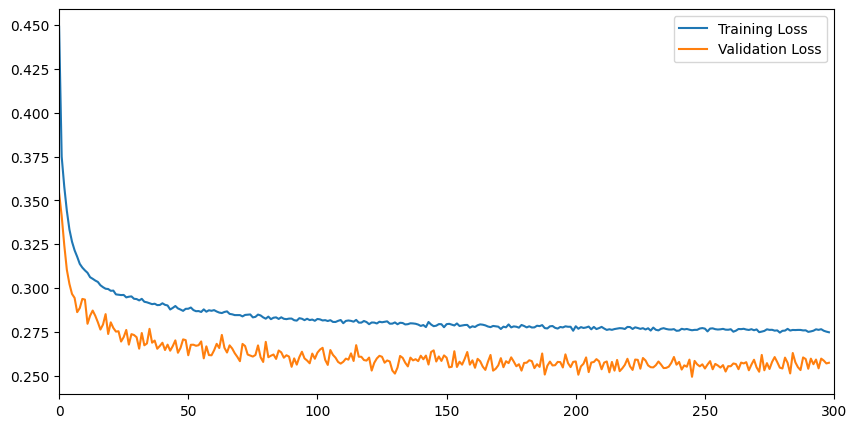

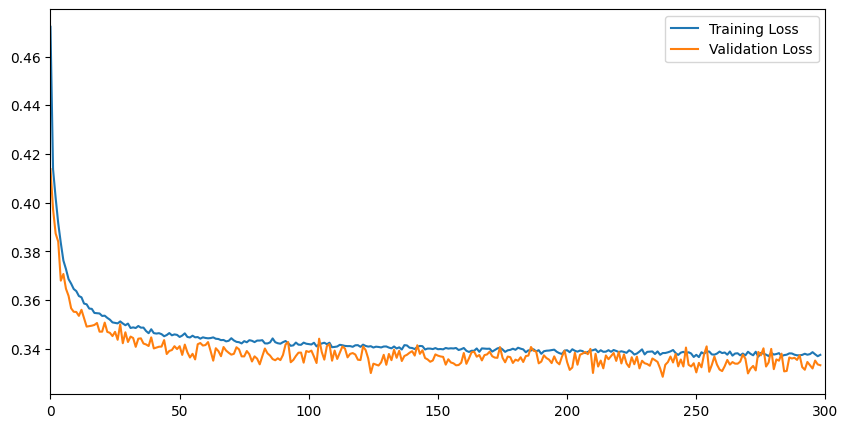

In [100]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500
save=True

nepochs=300
model_3_6=QuantileNetwork(quantiles=quantiles)
model_10=QuantileNetwork(quantiles=quantiles)
model_25=QuantileNetwork(quantiles=quantiles)
model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
n_nodes=64
sequence=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes,n_nodes),
    nn.ReLU(),
    nn.Linear(n_nodes, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

model_3_6.fit(X_train_3_6.to_numpy(),y_train_3_6.to_numpy(), 
          train_indices_3_6, 
          validation_indices_3_6, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/3_6',model=model_3_6,X_test=X_test_3_6,y_test=y_test_3_6)
    print("Model 3.6 saved...")

model_10.fit(X_train_10.to_numpy(),y_train_10.to_numpy(), 
          train_indices_10, 
          validation_indices_10, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/10',model=model_10,X_test=X_test_10,y_test=y_test_10)
    print("Model 10 saved...")

model_25.fit(X_train_25.to_numpy(),y_train_25.to_numpy(), 
          train_indices_25, 
          validation_indices_25, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:          
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/25',model=model_25,X_test=X_test_25,y_test=y_test_25)
    print("Model 25 saved...")

model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)
if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/all',model=model,X_test=X_test,y_test=y_test)
    print("Model all saved...")

In [137]:
preds = model.predict(X_test.to_numpy())
mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)
r2=r2_score(y_test.to_numpy(),preds[:,:,1])

In [138]:
print("MSE: "+str(mse))
print("PSNR: "+str(psnr))
print("Quant_rate: "+str(quant_rate))
print("R2 score: "+str(r2))

MSE: 0.01364196511049075
PSNR: 18.54092045334933
Quant_rate: [0.0844     0.47973333 0.8812    ]
R2 score: 0.6338210450178339


## Load trained models and Visualise

In [117]:
#Load models
model_3_6,X_test_3_6,y_test_3_6=hf.load_model_and_test_data('pytorch_models/test_COT_limits/3_6')
model_10,X_test_10,y_test_10=hf.load_model_and_test_data('pytorch_models/test_COT_limits/10')
model_25,X_test_25,y_test_25=hf.load_model_and_test_data('pytorch_models/test_COT_limits/25')
model,X_test,y_test=hf.load_model_and_test_data('pytorch_models/test_COT_limits/all')

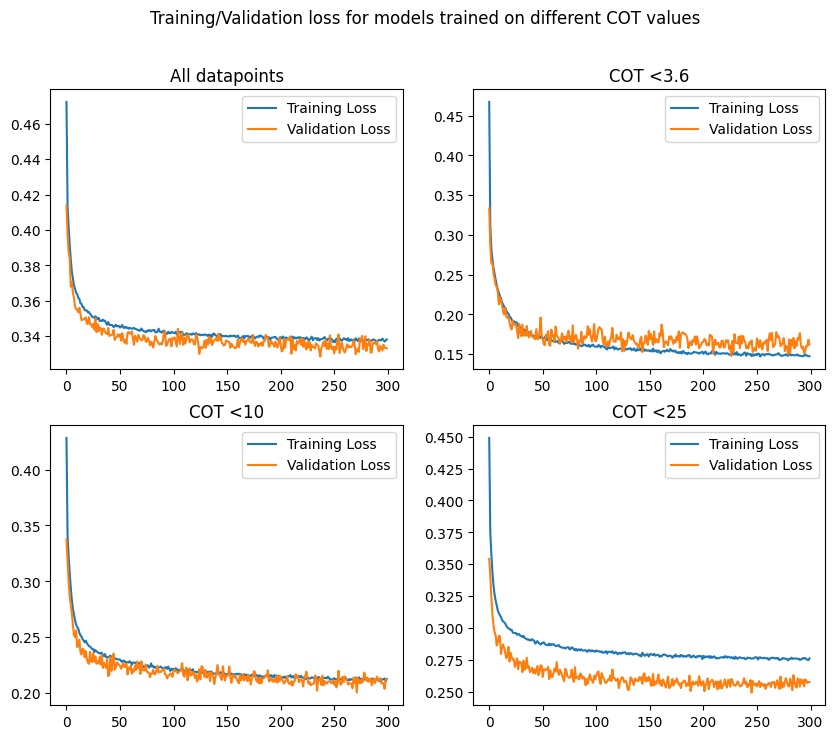

In [118]:
plt.rcParams["figure.figsize"] = [10, 8]
fig, ax =plt.subplots(nrows=2,ncols=2)
fig.suptitle("Training/Validation loss for models trained on different COT values")

ax[0,0].plot(model.train_loss.data.cpu().numpy())
ax[0,0].plot(model.val_loss.data.cpu().numpy())
ax[0,0].set_title("All datapoints")
ax[0,0].legend(['Training Loss','Validation Loss'])

ax[0,1].plot(model_3_6.train_loss.data.cpu().numpy())
ax[0,1].plot(model_3_6.val_loss.data.cpu().numpy())
ax[0,1].set_title("COT <3.6")
ax[0,1].legend(['Training Loss','Validation Loss'])

ax[1,0].plot(model_10.train_loss.data.cpu().numpy())
ax[1,0].plot(model_10.val_loss.data.cpu().numpy())
ax[1,0].set_title("COT <10")
ax[1,0].legend(['Training Loss','Validation Loss'])

ax[1,1].plot(model_25.train_loss.data.cpu().numpy())
ax[1,1].plot(model_25.val_loss.data.cpu().numpy())
ax[1,1].set_title("COT <25")
ax[1,1].legend(['Training Loss','Validation Loss'])

In [119]:
#Make predictions
y_preds_all=model.predict(X_test.to_numpy())
y_preds_3_6=model.predict(X_test_3_6.to_numpy())
y_preds_10=model.predict(X_test_10.to_numpy())
y_preds_25=model.predict(X_test_25.to_numpy())

In [120]:
## Calculate residuals
y_all=y_test.to_numpy()[:,0]
y_pred_all=y_preds_all[:,0,:]
res_all=y_all-y_pred_all[:,1]

y_3_6=y_test_3_6.to_numpy()[:,0]
y_pred_3_6=y_preds_3_6[:,0,:]
res_3_6=y_3_6-y_pred_3_6[:,1]

y_10=y_test_10.to_numpy()[:,0]
y_pred_10=y_preds_10[:,0,:]
res_10=y_10-y_pred_10[:,1]

y_25=y_test_25.to_numpy()[:,0]
y_pred_25=y_preds_25[:,0,:]
res_25=y_25-y_pred_25[:,1]


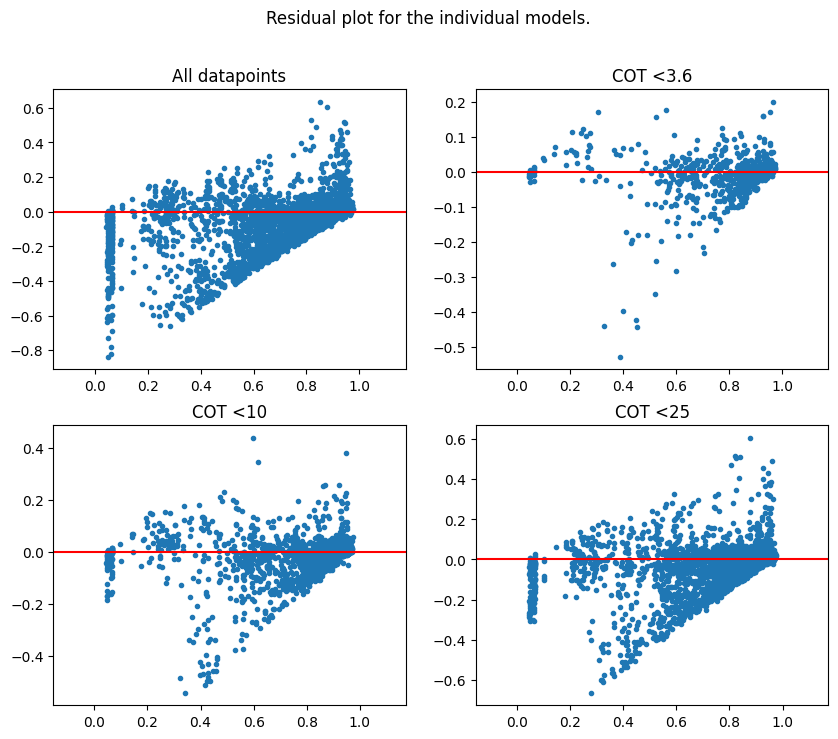

In [121]:
#Plot residuals
fig, ax =plt.subplots(nrows=2,ncols=2)
fig.suptitle("Residual plot for the individual models.")

ax[0,0].plot(y_all,res_all,'.')
ax[0,0].set_title("All datapoints")
ax[0,0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0,0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[0,1].plot(y_3_6,res_3_6,'.')
ax[0,1].set_title("COT <3.6")
ax[0,1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0,1].set_xlim((np.min(y_3_6)-0.2,np.max(y_3_6)+0.2))

ax[1,0].plot(y_10,res_10,'.')
ax[1,0].set_title("COT <10")
ax[1,0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1,0].set_xlim((np.min(y_10)-0.2,np.max(y_10)+0.2))

ax[1,1].plot(y_25,res_25,'.')
ax[1,1].set_title("COT <25")
ax[1,1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1,1].set_xlim((np.min(y_10)-0.2,np.max(y_10)+0.2))

plt.show()


### Residual comparison model trained on all vs model trained on COT <3.6

In [122]:
df_3_6=data_all[data_all['COT']<3.6]
df_X_3_6=df_3_6[X_labels]
df_y_3_6=df_3_6[y_labels]

preds=model.predict(df_X_3_6.to_numpy())
preds_3_6=model_3_6.predict(df_X_3_6.to_numpy())


In [123]:
#Calculate residuals
y_all=df_y_3_6.to_numpy()[:,0]
y_pred_all=preds[:,0,:]
res_all=y_all-y_pred_all[:,1]

y_3_6=df_y_3_6.to_numpy()[:,0]
y_pred_3_6=preds_3_6[:,0,:]
res_3_6=y_3_6-y_pred_3_6[:,1]

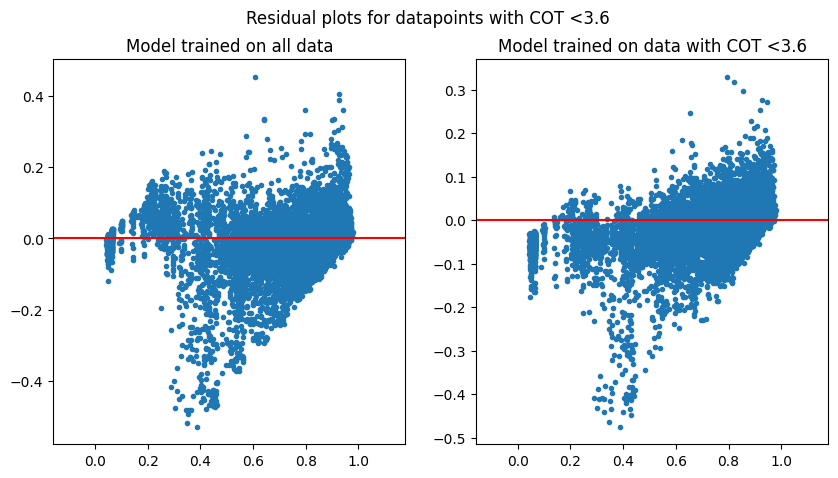

In [124]:
plt.rcParams["figure.figsize"] = [10, 5]
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Residual plots for datapoints with COT <3.6")

ax[0].plot(y_all,res_all,'.')
ax[0].set_title("Model trained on all data")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[1].plot(y_3_6,res_3_6,'.')
ax[1].set_title("Model trained on data with COT <3.6")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y_3_6)-0.2,np.max(y_3_6)+0.2))

plt.show()

In [125]:
r2_all=r2_score(df_y_3_6.to_numpy(),preds[:,:,1])
r2_3_6=r2_score(df_y_3_6.to_numpy(),preds_3_6[:,:,1])
mse_all=mean_squared_error(df_y_3_6.to_numpy(),preds[:,:,1])
mse_3_6=mean_squared_error(df_y_3_6.to_numpy(),preds_3_6[:,:,1])
print("R2 score for model trained on all data: "+str(r2_all))
print("R2 score for model trained on data with COT <3.6: "+str(r2_3_6))
print(" ")
print("MSE for model trained on all data: "+str(mse_all))
print("MSE for model trained on data with COT <3.6: "+str(mse_3_6))

R2 score for model trained on all data: 0.9114367918167856
R2 score for model trained on data with COT <3.6: 0.9462656201007523
 
MSE for model trained on all data: 0.0032327864364836536
MSE for model trained on data with COT <3.6: 0.0019614440135432196


#### Attempt only test data with COT <3.6

In [126]:
X_test_all_3_6=df.iloc[X_test.index][df.iloc[X_test.index]['COT']<3.6]
X_test_all_3_6=X_test_all_3_6[X_labels]

y_test_all_3_6=df.iloc[X_test.index][df.iloc[X_test.index]['COT']<3.6]
y_test_all_3_6=y_test_all_3_6[y_labels]

preds=model.predict(X_test_all_3_6.to_numpy())
preds_3_6=model_3_6.predict(X_test_3_6.to_numpy())

In [127]:
#Calculate residuals
y_all=y_test_all_3_6.to_numpy()[:,0]
y_pred_all=preds[:,0,:]
res_all=y_all-y_pred_all[:,1]

y_3_6=y_test_3_6.to_numpy()[:,0]
y_pred_3_6=preds_3_6[:,0,:]
res_3_6=y_3_6-y_pred_3_6[:,1]

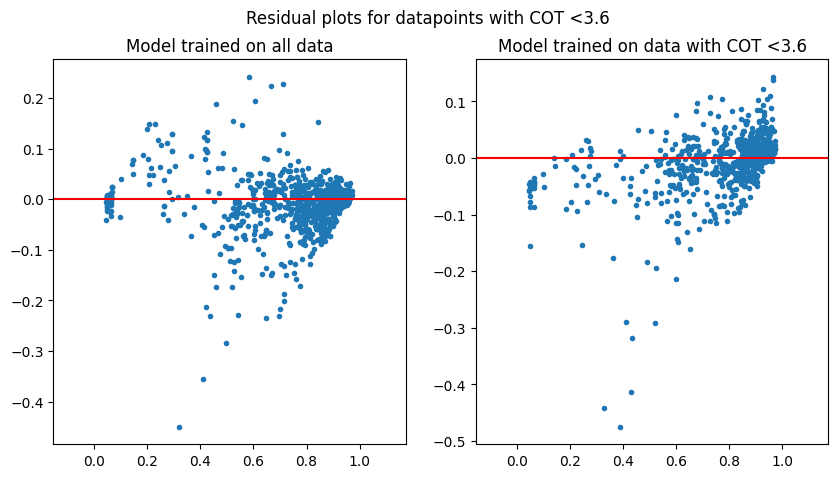

In [128]:
plt.rcParams["figure.figsize"] = [10, 5]
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Residual plots for datapoints with COT <3.6")

ax[0].plot(y_all,res_all,'.')
ax[0].set_title("Model trained on all data")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[1].plot(y_3_6,res_3_6,'.')
ax[1].set_title("Model trained on data with COT <3.6")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y_3_6)-0.2,np.max(y_3_6)+0.2))

plt.show()

In [131]:
r2_all=r2_score(y_test_all_3_6.to_numpy(),preds[:,:,1])
r2_3_6=r2_score(y_test_3_6.to_numpy(),preds_3_6[:,:,1])
mse_all=mean_squared_error(y_test_all_3_6.to_numpy(),preds[:,:,1])
mse_3_6=mean_squared_error(y_test_3_6.to_numpy(),preds_3_6[:,:,1])
print("R2 score for model trained on all data: "+str(r2_all))
print("R2 score for model trained on data with COT <3.6: "+str(r2_3_6))
print(" ")
print("MSE for model trained on all data: "+str(mse_all))
print("MSE for model trained on data with COT <3.6: "+str(mse_3_6))

R2 score for model trained on all data: 0.9500848781421212
R2 score for model trained on data with COT <3.6: 0.9399534768311123
 
MSE for model trained on all data: 0.001877452382018316
MSE for model trained on data with COT <3.6: 0.0021126013720914826
